In [1]:
DATA_ROOT_DIR="/media/sf_Share/ML_Group_Data/"
MAJOR_ROAD_TRANS=DATA_ROOT_DIR+"Detailed_Road_Transport-Major_Roads_Excel/LAEI2019-nox-pm-co2-major-roads-link-emissions.xlsx"
GRID_EMISSIONS=DATA_ROOT_DIR+"Grid_Emissions-Data_Excel/LAEI-2019-Emissions-Summary-including-Forecast.xlsx"
VKM_AADT_SPEEDS=DATA_ROOT_DIR+"Supporting_Info-VKM_flow_speeds_excel/laei-2019-major-roads-vkm-flows-speeds.xlsx"

CONCENTRATIONS_DATA_CSV_DIR=DATA_ROOT_DIR+"LAEI2019-Concentrations-Data-CSV/"
CONCENTRATIONS_DATA_NOX=CONCENTRATIONS_DATA_CSV_DIR+"laei_LAEI2019v3_CorNOx15_NOx.csv"
CONCENTRATIONS_DATA_PM25=CONCENTRATIONS_DATA_CSV_DIR+"laei_LAEI2019v3_CorNOx15_PM25.csv"

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import log_loss


# Objective - find important features in predicting the concentration of NOx and pm25 from vehicle emissions

# Two stages necessary since data for vehicle statistics and their emissions are correlated by TOID, which represents a stretch of road. Then emissions data, from a different source, and concentration of pollutants are correlated by grid coordinate. This second part is used to form a Linear Regression model which informs the emissions data in the first part.

---
# Part One: Load up TOID correlated data.
Conduct some cleanup and create dataframes for each sheet that has been loaded, although some we throw away instantly

In [8]:
vkm_aadt_speeds_df = pd.read_excel(VKM_AADT_SPEEDS, sheet_name="laei-2019-major-roads")
major_dict = pd.read_excel(MAJOR_ROAD_TRANS, sheet_name=None)

In [10]:
for sheet, df in major_dict.items():
    name = sheet.replace(" ", "_")
    name = name.replace(".", "")
    globals()[name] = df
    print(f"DataFrame created with name {name}")

DataFrame created with name NOx_Road_Link_Emissions
DataFrame created with name PM10_Road_Link_Emissions
DataFrame created with name PM25_Road_Link_Emissions
DataFrame created with name CO2_Road_Link_Emissions


In [12]:
# This is a massive object so delete it.
del major_dict 

In [14]:
NOx_Road_Link_Emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79439 entries, 0 to 79438
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TOID                            79439 non-null  object 
 1   pollutant                       79439 non-null  object 
 2   emissions-units                 79439 non-null  object 
 3   Road-Car-Petrol-2019            79381 non-null  float64
 4   Road-Car-Petrol-2025            79423 non-null  float64
 5   Road-Car-Petrol-2030            79423 non-null  float64
 6   Road-Car-Diesel-2019            79381 non-null  float64
 7   Road-Car-Diesel-2025            79423 non-null  float64
 8   Road-Car-Diesel-2030            79423 non-null  float64
 9   Road-Car-Electric-2019          79381 non-null  float64
 10  Road-Car-Electric-2025          79423 non-null  float64
 11  Road-Car-Electric-2030          79423 non-null  float64
 12  Road-PHV-Petrol-2019            

In [16]:
PM25_Road_Link_Emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238317 entries, 0 to 238316
Data columns (total 52 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   TOID                            238317 non-null  object 
 1   pollutant                       238317 non-null  object 
 2   pm-source                       238317 non-null  object 
 3   emissions-units                 238317 non-null  object 
 4   Road-Car-Petrol-2019            238143 non-null  float64
 5   Road-Car-Petrol-2025            238269 non-null  float64
 6   Road-Car-Petrol-2030            238269 non-null  float64
 7   Road-Car-Diesel-2019            238143 non-null  float64
 8   Road-Car-Diesel-2025            238269 non-null  float64
 9   Road-Car-Diesel-2030            238269 non-null  float64
 10  Road-Car-Electric-2019          238143 non-null  float64
 11  Road-Car-Electric-2025          238269 non-null  float64
 12  Road-Car-Electri

### We are interested 2019 data, so filter only that is included

In [19]:
target_year = "2019"
PM25_Emissions = PM25_Road_Link_Emissions[[col for col in PM25_Road_Link_Emissions.columns if target_year in col]].copy()
NOx_Emissions = NOx_Road_Link_Emissions[[col for col in NOx_Road_Link_Emissions.columns if target_year in col]].copy()

### Total emissions for all classes of vehicle for each pollutant is added to the dataframe, along with TOID, which is the correlating feature

In [22]:
NOx_Emissions["NOX_Total"] = NOx_Emissions.sum(axis=1)
PM25_Emissions["PM25_Total"] = PM25_Emissions.sum(axis=1)
NOx_Emissions["TOID"] = NOx_Road_Link_Emissions["TOID"].copy()
PM25_Emissions["TOID"] = PM25_Road_Link_Emissions["TOID"].copy()

In [24]:
PM25_Emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238317 entries, 0 to 238316
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Road-Car-Petrol-2019            238143 non-null  float64
 1   Road-Car-Diesel-2019            238143 non-null  float64
 2   Road-Car-Electric-2019          238143 non-null  float64
 3   Road-PHV-Petrol-2019            238143 non-null  float64
 4   Road-PHV-Diesel-2019            238143 non-null  float64
 5   Road-PHV-Electric-2019          238143 non-null  float64
 6   Road-LGV-Petrol-2019            238143 non-null  float64
 7   Road-LGV-Diesel-2019            238143 non-null  float64
 8   Road-LGV-Electric-2019          238143 non-null  float64
 9   Road-HGV-Rigid-2019             238143 non-null  float64
 10  Road-HGV-Articulated-2019       238143 non-null  float64
 11  Road-TfL-Bus-2019               238164 non-null  float64
 12  Road-Non-TfL-Bus

In [26]:
PM25_Emissions.describe(include=['O'])

,TOID
count,238317
unique,79439
top,osgb4000000027865913
freq,3


In [28]:
NOx_Emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79439 entries, 0 to 79438
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Road-Car-Petrol-2019            79381 non-null  float64
 1   Road-Car-Diesel-2019            79381 non-null  float64
 2   Road-Car-Electric-2019          79381 non-null  float64
 3   Road-PHV-Petrol-2019            79381 non-null  float64
 4   Road-PHV-Diesel-2019            79381 non-null  float64
 5   Road-PHV-Electric-2019          79381 non-null  float64
 6   Road-LGV-Petrol-2019            79381 non-null  float64
 7   Road-LGV-Diesel-2019            79381 non-null  float64
 8   Road-LGV-Electric-2019          79381 non-null  float64
 9   Road-HGV-Rigid-2019             79381 non-null  float64
 10  Road-HGV-Articulated-2019       79381 non-null  float64
 11  Road-TfL-Bus-2019               79388 non-null  float64
 12  Road-Non-TfL-Bus-or-Coach-2019  

In [30]:
NOx_Emissions.describe(include=['O'])

,TOID
count,79439
unique,79439
top,osgb4000000027865913
freq,1


### Observations are that the number of unique TOIDs is the same in each dataframe and there are some blank values

Drop all rows that have blank and remove columns that are currently not needed

In [34]:
NOx_Emissions = NOx_Emissions.loc[:, ["NOX_Total","TOID"]]
PM25_Emissions = PM25_Emissions.loc[:, ["PM25_Total","TOID"]]

In [36]:
NOx_Emissions.dropna(inplace=True)
PM25_Emissions.dropna(inplace=True)

# Now we have emission data by TOID in two different dataframes, next add vehicle speed 
cleanup first

In [39]:
vkm_aadt_speeds_df.columns = vkm_aadt_speeds_df.columns.str.strip()
vkm_aadt_speeds_df.columns

Index(['Year', 'TOID', 'LAEI Zone', 'Borough', 'Road Classification',
       'AADT Motorcycle', 'AADT Taxi', 'AADT Petrol Car', 'AADT Diesel Car',
       'AADT Electric Car', 'AADT Petrol PHV', 'AADT Diesel PHV',
       'AADT Electric PHV', 'AADT Petrol LGV', 'AADT Diesel LGV',
       'AADT Electric LGV', 'AADT 2019 - HGVs - Rigid - 2 Axles',
       'AADT 2019 - HGVs - Rigid - 3 Axles',
       'AADT 2019 - HGVs - Rigid - 4 or more Axles',
       'AADT 2019 - HGVs - Articulated - 3 to 4 Axles',
       'AADT 2019 - HGVs - Articulated - 5 Axles',
       'AADT 2019 - HGVs - Articulated - 6 Axles', 'AADT 2019 - Buses',
       'AADT 2019 - Coaches', 'AADT 2019 - Total',
       'Speed (km/hr) - Except Buses', 'Speed (km/hr) - Buses Only',
       'Link Length (m)', 'VKM Motorcycle', 'VKM Taxi', 'VKM Petrol Car',
       'VKM Diesel Car', 'VKM Electric Car', 'VKM Petrol PHV',
       'VKM Diesel PHV', 'VKM Electric PHV', 'VKM Petrol LGV',
       'VKM Diesel LGV', 'VKM Electric LGV',
       'VKM 2

In [41]:
speed_data = vkm_aadt_speeds_df.loc[:, ["TOID","Speed (km/hr) - Except Buses"]]
speed_data.rename(columns = {"Speed (km/hr) - Except Buses":"Speed"}, inplace=True)
speed_data.loc[:, 'Speed'] = pd.to_numeric(speed_data['Speed'], errors='coerce')
average_speed = speed_data.groupby('TOID', as_index=False)['Speed'].mean()
del speed_data
average_speed

/tmp/ipykernel_19239/3734700780.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  speed_data.loc[:, 'Speed'] = pd.to_numeric(speed_data['Speed'], errors='coerce')


,TOID,Speed
0,osgb4000000027865913,102.0
1,osgb4000000027865914,107.0
2,osgb4000000027865915,96.0
3,osgb4000000027865916,103.0
4,osgb4000000027865917,102.0
...,...,...
79432,osgb5000005157986967,21.0
79433,osgb5000005161615710,21.0
79434,osgb5000005161615711,21.0
79435,osgb5000005163065844,19.0


## Now there is a third dataframe that contains speed and TOID

In [44]:
print(f"Number of TOIDs in Nox is {NOx_Emissions.nunique().iloc[0]}, length of dataframe is {len(NOx_Emissions)}")
print(f"Number of TOIDs in pm25 is {PM25_Emissions.nunique().iloc[0]}, length of dataframe is {len(PM25_Emissions)}")

Number of TOIDs in Nox is 78770, length of dataframe is 79439
Number of TOIDs in pm25 is 236308, length of dataframe is 238317


### pm25 has a greater number of sources from a vehicle, including exhaust as well as tyre and brake wear, so needs averaging per TOID

In [47]:
PM25_Emissions = PM25_Emissions.groupby('TOID', as_index=False).mean()

## Now start a summary DataFrame which will bring the three DataFrames created so far together, by TOID

In [50]:
summary_df = pd.DataFrame()
summary_df["TOID"] = NOx_Emissions.loc[:, "TOID"].copy()
summary_df['Speed'] = 0
mapping_dict = average_speed.set_index('TOID')['Speed'].to_dict()
summary_df.loc[:, 'Speed'] = average_speed['TOID'].map(mapping_dict)

mapping_dict = NOx_Emissions.set_index('TOID')['NOX_Total'].to_dict()
summary_df.loc[:, 'NOX_Total'] = NOx_Emissions['TOID'].map(mapping_dict)

mapping_dict = PM25_Emissions.set_index('TOID')['PM25_Total'].to_dict()
summary_df.loc[:, 'PM25_Total'] = PM25_Emissions['TOID'].map(mapping_dict)

In [51]:
del PM25_Emissions, NOx_Emissions,average_speed

In [54]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79439 entries, 0 to 79438
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TOID        79439 non-null  object 
 1   Speed       79436 non-null  float64
 2   NOX_Total   79439 non-null  float64
 3   PM25_Total  79439 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.4+ MB


# We know the emissions, what caused them?

### Group by aadt (annual average daily traffic), ensuring the TOID is carried into the new DataFrame

In [58]:
aadt_columns = vkm_aadt_speeds_df.filter(like='AADT', axis=1).copy()
aadt_columns["TOID"] = vkm_aadt_speeds_df.loc[:, "TOID"].copy()
aadt_columns.columns = aadt_columns.columns.str.strip().str.replace(' ', '_')
aadt_columns.describe(include=['O'])

,AADT_Motorcycle,AADT_Taxi,AADT_Petrol_Car,AADT_Diesel_Car,AADT_Electric_Car,AADT_Petrol_PHV,AADT_Diesel_PHV,AADT_Electric_PHV,AADT_Petrol_LGV,AADT_Diesel_LGV,...,AADT_2019_-_HGVs_-_Rigid_-_2_Axles,AADT_2019_-_HGVs_-_Rigid_-_3_Axles,AADT_2019_-_HGVs_-_Rigid_-_4_or_more_Axles,AADT_2019_-_HGVs_-_Articulated_-_3_to_4_Axles,AADT_2019_-_HGVs_-_Articulated_-_5_Axles,AADT_2019_-_HGVs_-_Articulated_-_6_Axles,AADT_2019_-_Buses,AADT_2019_-_Coaches,AADT_2019_-_Total,TOID
count,79437,79437,79437,79437,79437,79437,79437,79437,79437,79437,...,79437,79437,79437,79437,79437,79437,79437,79437,79437,79437
unique,1722,3119,12632,9719,233,2246,1615,68,137,5901,...,1852,450,752,324,749,1075,1939,1253,22870,79437
top,-,-,-,-,15,-,-,1,3,-,...,-,-,-,-,-,-,-,-,-,osgb4000000027947700
freq,765,1671,1267,1267,1631,5423,5423,17249,3700,1366,...,3517,5636,5664,12142,8589,8453,25624,12893,689,1


In [59]:
aadt_columns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79437 entries, 0 to 79436
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   AADT_Motorcycle                                79437 non-null  object
 1   AADT_Taxi                                      79437 non-null  object
 2   AADT_Petrol_Car                                79437 non-null  object
 3   AADT_Diesel_Car                                79437 non-null  object
 4   AADT_Electric_Car                              79437 non-null  object
 5   AADT_Petrol_PHV                                79437 non-null  object
 6   AADT_Diesel_PHV                                79437 non-null  object
 7   AADT_Electric_PHV                              79437 non-null  object
 8   AADT_Petrol_LGV                                79437 non-null  object
 9   AADT_Diesel_LGV                                79437 non-null

## Prepare the data, remove white space and set "-" to NaN. There are ~73k rows before dropna and ~45k after

In [63]:
aadt_columns = aadt_columns.applymap(lambda x: x.strip() if isinstance(x, str) else x)
aadt_columns = aadt_columns.replace("-",np.nan)
aadt_columns.dropna(inplace=True) 

In [64]:
aadt_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45043 entries, 5 to 78319
Data columns (total 21 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   AADT_Motorcycle                                45043 non-null  float64
 1   AADT_Taxi                                      45043 non-null  float64
 2   AADT_Petrol_Car                                45043 non-null  float64
 3   AADT_Diesel_Car                                45043 non-null  float64
 4   AADT_Electric_Car                              45043 non-null  float64
 5   AADT_Petrol_PHV                                45043 non-null  float64
 6   AADT_Diesel_PHV                                45043 non-null  float64
 7   AADT_Electric_PHV                              45043 non-null  float64
 8   AADT_Petrol_LGV                                45043 non-null  float64
 9   AADT_Diesel_LGV                                450

### Group by vkm (vehicle kilometeres), ensuring the TOID is carried into the new DataFrame

In [68]:
vkm_columns = vkm_aadt_speeds_df.filter(like='VKM', axis=1).copy()
vkm_columns["TOID"] = vkm_aadt_speeds_df.loc[:, "TOID"].copy()
vkm_columns.columns = vkm_columns.columns.str.strip().str.replace(' ', '_')
vkm_columns.info()
del vkm_aadt_speeds_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79437 entries, 0 to 79436
Data columns (total 21 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   VKM_Motorcycle                                79437 non-null  object
 1   VKM_Taxi                                      79437 non-null  object
 2   VKM_Petrol_Car                                79437 non-null  object
 3   VKM_Diesel_Car                                79437 non-null  object
 4   VKM_Electric_Car                              79437 non-null  object
 5   VKM_Petrol_PHV                                79437 non-null  object
 6   VKM_Diesel_PHV                                79437 non-null  object
 7   VKM_Electric_PHV                              79437 non-null  object
 8   VKM_Petrol_LGV                                79437 non-null  object
 9   VKM_Diesel_LGV                                79437 non-null  object
 10

### Prepare the data, remove white space and set "-" to NaN. There are ~73k rows before dropna and ~45k after

In [71]:
vkm_columns = vkm_columns.applymap(lambda x: x.strip() if isinstance(x, str) else x)
vkm_columns = vkm_columns.replace("-",np.nan)
vkm_columns.dropna(inplace=True) 

## Update the DataFrame with VKM and AADT info

In [73]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79439 entries, 0 to 79438
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TOID        79439 non-null  object 
 1   Speed       79436 non-null  float64
 2   NOX_Total   79439 non-null  float64
 3   PM25_Total  79439 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.4+ MB


In [76]:
summary_df = pd.merge(summary_df, aadt_columns, on='TOID', how='outer')

In [78]:
summary_df = pd.merge(summary_df, vkm_columns, on='TOID', how='outer')

### Drop the total columns as we dont want them and drop any rows with NaNs

In [81]:
summary_df.drop(columns=["VKM_2019_-_Total","AADT_2019_-_Total"], axis=1, inplace=True)
summary_df.dropna(inplace=True)


In [83]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45027 entries, 192 to 79382
Data columns (total 42 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   TOID                                           45027 non-null  object 
 1   Speed                                          45027 non-null  float64
 2   NOX_Total                                      45027 non-null  float64
 3   PM25_Total                                     45027 non-null  float64
 4   AADT_Motorcycle                                45027 non-null  float64
 5   AADT_Taxi                                      45027 non-null  float64
 6   AADT_Petrol_Car                                45027 non-null  float64
 7   AADT_Diesel_Car                                45027 non-null  float64
 8   AADT_Electric_Car                              45027 non-null  float64
 9   AADT_Petrol_PHV                                4

In [85]:
summary_df.head()

,TOID,Speed,NOX_Total,PM25_Total,AADT_Motorcycle,AADT_Taxi,AADT_Petrol_Car,AADT_Diesel_Car,AADT_Electric_Car,AADT_Petrol_PHV,...,VKM_Diesel_LGV,VKM_Electric_LGV,VKM_2019_-_HGVs_-_Rigid_-_2_Axles,VKM_2019_-_HGVs_-_Rigid_-_3_Axles,VKM_2019_-_HGVs_-_Rigid_-_4_or_more_Axles,VKM_2019_-_HGVs_-_Articulated_-_3_to_4_Axles,VKM_2019_-_HGVs_-_Articulated_-_5_Axles,VKM_2019_-_HGVs_-_Articulated_-_6_Axles,VKM_2019_-_Buses,VKM_2019_-_Coaches
192,osgb4000000027887298,30.0,0.896184,0.020956,107.0,14.0,4602.0,3181.0,27.0,86.0,...,162590.0,357.0,8744.0,1780.0,3482.0,1238.0,6577.0,8744.0,4875.0,10911.0
196,osgb4000000027887313,45.0,0.553449,0.015519,171.0,29.0,10533.0,7279.0,62.0,564.0,...,106375.0,233.0,18887.0,5143.0,3429.0,1686.0,5143.0,3429.0,3457.0,815.0
213,osgb4000000027887403,118.0,2.891096,0.027219,217.0,16.0,12493.0,8634.0,74.0,370.0,...,384207.0,843.0,117164.0,31848.0,21310.0,10539.0,31848.0,21310.0,2480.0,75010.0
222,osgb4000000027887455,52.0,0.126330,0.003169,17.0,6.0,1028.0,710.0,6.0,28.0,...,23814.0,52.0,3520.0,943.0,629.0,314.0,943.0,629.0,754.0,1634.0
325,osgb4000000027909176,118.0,0.670890,0.006510,217.0,16.0,12493.0,8634.0,74.0,370.0,...,91573.0,201.0,36716.0,9992.0,6686.0,3306.0,9992.0,6686.0,591.0,129.0


# FIRST ALGORITHM
Use the RandomForestRegressor to identify the key contributors to each gas.
This algorithm is not sensitive to scaling, so the data is not scaled

In [88]:
list_of_not_gas = []
for column in summary_df.columns:
    if 'AADT' in column or 'VKM' in column:
        list_of_not_gas.append(column)
list_of_not_gas

['AADT_Motorcycle',
 'AADT_Taxi',
 'AADT_Petrol_Car',
 'AADT_Diesel_Car',
 'AADT_Electric_Car',
 'AADT_Petrol_PHV',
 'AADT_Diesel_PHV',
 'AADT_Electric_PHV',
 'AADT_Petrol_LGV',
 'AADT_Diesel_LGV',
 'AADT_Electric_LGV',
 'AADT_2019_-_HGVs_-_Rigid_-_2_Axles',
 'AADT_2019_-_HGVs_-_Rigid_-_3_Axles',
 'AADT_2019_-_HGVs_-_Rigid_-_4_or_more_Axles',
 'AADT_2019_-_HGVs_-_Articulated_-_3_to_4_Axles',
 'AADT_2019_-_HGVs_-_Articulated_-_5_Axles',
 'AADT_2019_-_HGVs_-_Articulated_-_6_Axles',
 'AADT_2019_-_Buses',
 'AADT_2019_-_Coaches',
 'VKM_Motorcycle',
 'VKM_Taxi',
 'VKM_Petrol_Car',
 'VKM_Diesel_Car',
 'VKM_Electric_Car',
 'VKM_Petrol_PHV',
 'VKM_Diesel_PHV',
 'VKM_Electric_PHV',
 'VKM_Petrol_LGV',
 'VKM_Diesel_LGV',
 'VKM_Electric_LGV',
 'VKM_2019_-_HGVs_-_Rigid_-_2_Axles',
 'VKM_2019_-_HGVs_-_Rigid_-_3_Axles',
 'VKM_2019_-_HGVs_-_Rigid_-_4_or_more_Axles',
 'VKM_2019_-_HGVs_-_Articulated_-_3_to_4_Axles',
 'VKM_2019_-_HGVs_-_Articulated_-_5_Axles',
 'VKM_2019_-_HGVs_-_Articulated_-_6_Axles',
 

## NOX

In [91]:
vehicle_metrics = summary_df[list_of_not_gas]

In [93]:
NOX = summary_df['NOX_Total']

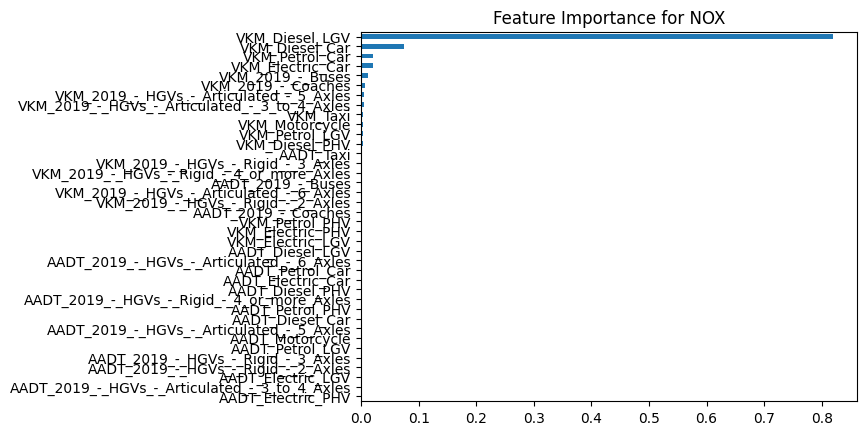

In [95]:
model = RandomForestRegressor()
VM_train, VM_test, NOX_train, NOX_test = train_test_split(vehicle_metrics, NOX, test_size=0.2, random_state=42)
model.fit(VM_train, NOX_train)
NOX_pred = model.predict(VM_test)

feature_importances = pd.Series(model.feature_importances_, index=vehicle_metrics.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance for NOX')
plt.show()

In [96]:
NOX_MAE = mean_absolute_error(NOX_test, NOX_pred)
NOX_MSE = mean_squared_error(NOX_test, NOX_pred)
NOX_R2 = r2_score(NOX_test, NOX_pred)

print(f"RandomForestRegressor NOX Performance:\n MAE: {NOX_MAE}\n MSE: {NOX_MSE}\n R²: {NOX_R2}")

RandomForestRegressor NOX Performance:
 MAE: 0.0611848169048847
 MSE: 0.03249287145630195
 R²: 0.9437512938818996


## PM25

In [98]:
PM25 = summary_df['PM25_Total']

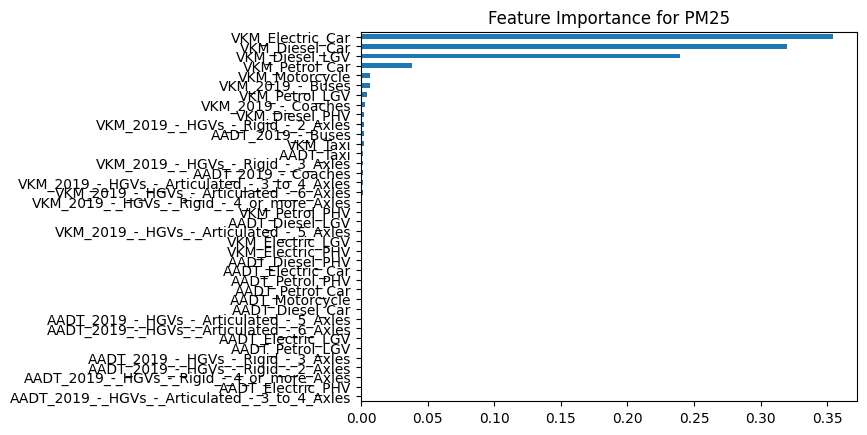

In [99]:
VM_train, VM_test, Pm25_train, Pm25_test = train_test_split(vehicle_metrics, PM25, test_size=0.2, random_state=42)
model = RandomForestRegressor()
model.fit(VM_train, Pm25_train)

PM25_pred = model.predict(VM_test)

feature_importances = pd.Series(model.feature_importances_, index=vehicle_metrics.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance for PM25')
plt.show()

In [100]:
PM25_MAE = mean_absolute_error(Pm25_test, PM25_pred)
PM25_MSE = mean_squared_error(Pm25_test, PM25_pred)
PM25_R2 = r2_score(Pm25_test, PM25_pred)

print(f"RandomForestRegressor PM25 Performance:\n MAE: {PM25_MAE}\n MSE: {PM25_MSE}\n R²: {PM25_R2}")

RandomForestRegressor PM25 Performance:
 MAE: 0.0006551445464939765
 MSE: 9.995968201595091e-06
 R²: 0.9676926974916716


# Do PCA to see if that compliments the above findings, which are that four features, the Vehicle Kilometre of Diesel Cars, Electric Cars, Petrol Cars and Diesel LGVs contribute mostly to each pollutant

In [109]:
list_of_features = summary_df.columns.to_list()

list_of_features.remove("TOID")
list_of_features.remove("PM25_Total")
list_of_features.remove("NOX_Total")
X = summary_df[list_of_features]

In [111]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [115]:
pca = PCA(n_components=4) #Three gases and four vehicle paramters
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca_df.head()

,PC1,PC2,PC3,PC4
0,0.388211,-2.261926,-1.122306,-0.495092
1,3.698874,1.374050,-3.560743,-1.352199
2,16.257425,-2.147301,-8.439360,-2.479646
3,-3.103916,-2.512625,-0.071834,-0.989244
4,9.863824,5.004262,-12.406128,-4.074521


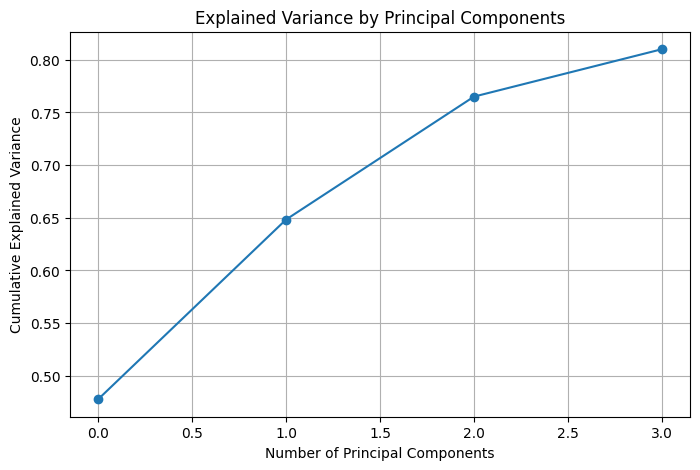

In [117]:
# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

The above shows that 80% of the variance is explained by 7 of the variables

In [70]:
del pca_df, principal_components, pca, X, X_scaled, scaler

## Top three from each table combined captures four features, re-run randomforestregression, for summary

In [72]:
TOP_IMPORTANCE = ["VKM_Diesel_LGV", "VKM_Diesel_Car", "VKM_Petrol_Car", "VKM_Electric_Car"]

In [73]:
import_vehicle_metrics = summary_df[TOP_IMPORTANCE]

### NOX

In [75]:
nox_total = summary_df['NOX_Total']

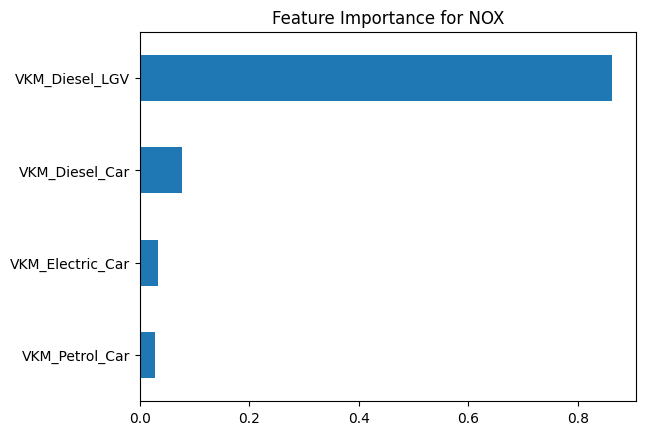

In [76]:
model = RandomForestRegressor()
model.fit(import_vehicle_metrics, nox_total)
feature_importances = pd.Series(model.feature_importances_, index=import_vehicle_metrics.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance for NOX')
plt.show()

# PM25

In [78]:
pm25_total = summary_df['PM25_Total']

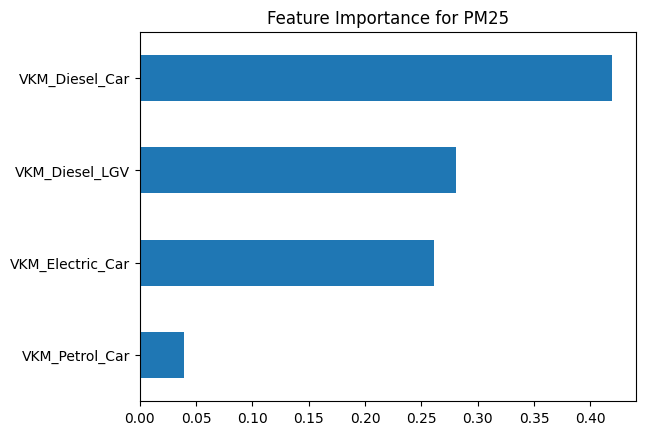

In [79]:
model = RandomForestRegressor()
model.fit(import_vehicle_metrics, pm25_total)
feature_importances = pd.Series(model.feature_importances_, index=import_vehicle_metrics.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance for PM25')
plt.show()

---
# Part Two: Load up grid coordinate correlated data

In [81]:
pm25_concentration = pd.read_csv(CONCENTRATIONS_DATA_PM25)
nox_concentration = pd.read_csv(CONCENTRATIONS_DATA_NOX)
grid_df = pd.read_excel(GRID_EMISSIONS, sheet_name="Emissions by Grid ID")

In [82]:
nox_concentration.head()

,x,y,conc
0,519100,203440,37.54391
1,519120,203440,40.60276
2,519140,203440,47.19806
3,519160,203440,43.32369
4,519180,203440,39.57808


In [83]:
pm25_concentration.head()

,x,y,conc
0,519100,203440,9.567125
1,519120,203440,9.687501
2,519140,203440,9.953107
3,519160,203440,9.791943
4,519180,203440,9.635820


In [84]:
nox_concentration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851964 entries, 0 to 5851963
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conc    float64
dtypes: float64(1), int64(2)
memory usage: 133.9 MB


In [85]:
pm25_concentration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5851964 entries, 0 to 5851963
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conc    float64
dtypes: float64(1), int64(2)
memory usage: 133.9 MB


In [86]:
grid_df.head()

,Year,Grid ID 2019,LAEI 1km2 ID,Easting,Northing,Borough,Zone,Main Source Category,Sector,Source,...,n2o,nh3,nmvoc,nox,pb,pcb,pm10,pm2.5,so2,Emissions Unit
0,2030,1,5910,510500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019183,0.019183,NaN,tonnes/annum
1,2030,2,5911,511500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.015719,0.015719,NaN,tonnes/annum
2,2030,3,5912,512500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.019878,0.019878,NaN,tonnes/annum
3,2030,4,5915,515500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.020946,0.020946,NaN,tonnes/annum
4,2030,5,5916,516500,203500,Non GLA,Non GLA,Domestic,Biomass,Wood Burning,...,NaN,NaN,NaN,NaN,NaN,NaN,0.020105,0.020105,NaN,tonnes/annum


### Cleanup the grid data, filtering by interesting columns and the year 2019. Coordinates are Easting/Northing here.

In [88]:
YEAR=2019
GRID_INTERESTING_COLUMNS = ["Easting", "Northing", "Sector", "nox", "pm2.5"]
grid_df_2019 = grid_df[grid_df['Year'] == YEAR]
grid_df_2019 = grid_df_2019[GRID_INTERESTING_COLUMNS]

del grid_df, GRID_INTERESTING_COLUMNS
grid_df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143976 entries, 285264 to 429239
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Easting   143976 non-null  int64  
 1   Northing  143976 non-null  int64  
 2   Sector    143976 non-null  object 
 3   nox       123216 non-null  float64
 4   pm2.5     140516 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 6.6+ MB


## Remove any easting/northing that isnt uniquely due to road transport

### Combine easting/northing into single column to make filtering easier

In [91]:
grid_df_2019['CombinedEastNorth'] = grid_df_2019['Easting'].astype(str) + grid_df_2019['Northing'].astype(str)
grid_df_2019.drop(columns=["Easting", "Northing"], axis=1, inplace=True)

In [92]:
grid_df_2019.head()

,Sector,nox,pm2.5,CombinedEastNorth
285264,Biomass,NaN,0.021923,510500203500
285265,Biomass,NaN,0.017965,511500203500
285266,Biomass,NaN,0.022718,512500203500
285267,Biomass,NaN,0.023939,515500203500
285268,Biomass,NaN,0.022977,516500203500


In [93]:
grid_df_2019["CombinedEastNorth"].value_counts()

533500182500    252
533500180500    252
532500182500    210
533500181500    210
533500171500    168
               ... 
531500158500     42
507500169500     34
503500173500     34
509500159500     34
506500175500     34
Name: CombinedEastNorth, Length: 2466, dtype: int64

As no CombinedEastNorth is unique, we cannot look for one that only has emissions from Road Transport, it is necessary to group by combined coordinate, and sum each pollutant into a new DataFrame. The amount that is contributed by Road Transport is then recorded as a percentage. So we get Percentage of emission in a coordinate that is due to Road Transport for each gas.

In [95]:
nox_grouped_df = grid_df_2019.groupby(['CombinedEastNorth', 'Sector'])['nox'].sum().reset_index()
total_nox_by_east_north = grid_df_2019.groupby('CombinedEastNorth')['nox'].sum()
nox_grouped_df['percentage_of_total_nox'] = nox_grouped_df.apply(
    lambda row: (row['nox'] / total_nox_by_east_north[row['CombinedEastNorth']]) * 100, axis=1
)


pm25_grouped_df = grid_df_2019.groupby(['CombinedEastNorth', 'Sector'])['pm2.5'].sum().reset_index()
total_pm25_by_east_north = grid_df_2019.groupby('CombinedEastNorth')['pm2.5'].sum()
pm25_grouped_df['percentage_of_total_pm25'] = pm25_grouped_df.apply(
    lambda row: (row['pm2.5'] / total_pm25_by_east_north[row['CombinedEastNorth']]) * 100, axis=1
)



In [96]:
nox_cleaned = nox_grouped_df[nox_grouped_df['percentage_of_total_nox'] != 0.0]
pm25_cleaned = pm25_grouped_df[pm25_grouped_df['percentage_of_total_pm25'] != 0.0]
nox_cleaned = nox_cleaned[nox_cleaned['Sector'] == "Road Transport"]
pm25_cleaned = pm25_cleaned[pm25_cleaned['Sector'] == "Road Transport"]

del nox_grouped_df, pm25_grouped_df, grid_df_2019

Sector is now the same for all entries so drop it

In [98]:
nox_cleaned.drop(columns=["Sector"], axis=1, inplace=True)
pm25_cleaned.drop(columns=["Sector"], axis=1, inplace=True)

Merge the two dataframes together

In [100]:
combined_cleaned_df = pd.merge(nox_cleaned, pm25_cleaned, on='CombinedEastNorth', how='outer')

### Add the pollution concentrations from the other datasources. Coordinates are X/Y here. Again combining coordinates makes filtering easier.

In [102]:
pm25_concentration['CombinedXY'] = pm25_concentration['x'].astype(str) + pm25_concentration['y'].astype(str)
pm25_concentration.drop(columns=["x", "y"], axis=1, inplace=True)
nox_concentration['CombinedXY'] = nox_concentration['x'].astype(str) + nox_concentration['y'].astype(str)
nox_concentration.drop(columns=["x", "y"], axis=1, inplace=True)

Group the pollutants by Coordinate, summing all entries

In [104]:
nox_concentration = nox_concentration.groupby('CombinedXY')['conc'].sum()
pm25_concentration = pm25_concentration.groupby('CombinedXY')['conc'].sum()

Add the pollutants to combined DataFrame, mapped by CombinedEastNorth, which matches CombinedXY in this data

In [106]:
combined_cleaned_df['nox_concentration'] = combined_cleaned_df['CombinedEastNorth'].map(nox_concentration)
combined_cleaned_df['pm25_concentration'] = combined_cleaned_df['CombinedEastNorth'].map(pm25_concentration)
combined_cleaned_df.dropna(inplace=True)

Work out the concentration attributable to road traffic, using percentages

In [108]:
combined_cleaned_df['road_emission_caused_concentration_nox'] = combined_cleaned_df.apply(
    lambda row: (row['percentage_of_total_nox'] / 100) * row['nox_concentration'], axis=1
)

combined_cleaned_df['road_emission_caused_concentration_pm25'] = combined_cleaned_df.apply(
    lambda row: (row['percentage_of_total_pm25'] / 100) * row['pm25_concentration'], axis=1
)

Drop unnecessary columns

In [110]:
combined_cleaned_df.drop(columns=["CombinedEastNorth","percentage_of_total_nox","percentage_of_total_pm25","nox_concentration","pm25_concentration"], axis=1, inplace=True)

In [111]:
combined_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2338 entries, 3 to 2464
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   nox                                      2338 non-null   float64
 1   pm2.5                                    2338 non-null   float64
 2   road_emission_caused_concentration_nox   2338 non-null   float64
 3   road_emission_caused_concentration_pm25  2338 non-null   float64
dtypes: float64(4)
memory usage: 91.3 KB


### Create Linear Models so that we can predict a concentration of pollutant based on emission
nox model

In [244]:
NOX_Emissions = combined_cleaned_df["nox"].values.reshape(-1, 1)
NOX_Concentration = combined_cleaned_df["road_emission_caused_concentration_nox"]

NOX_EM_train, NOX_EM_test, NOX_CONC_train, NOX_CONC_test = train_test_split(NOX_Emissions, NOX_Concentration, test_size=0.2, random_state=42)

nox_emission_conc_model = make_pipeline(StandardScaler(), LinearRegression())
nox_emission_conc_model.fit(NOX_EM_train, NOX_CONC_train)
NOX_CONC_pred = nox_emission_conc_model.predict(NOX_EM_test)
combined_cleaned_df['Predicted_Nox_Concentration'] = nox_emission_conc_model.predict(NOX_Emissions)

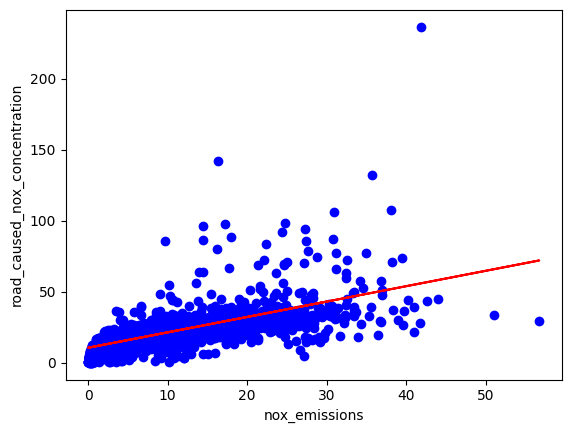

In [246]:
%matplotlib inline
plt.xlabel("nox_emissions")
plt.ylabel("road_caused_nox_concentration")
plt.scatter(combined_cleaned_df.nox, combined_cleaned_df["road_emission_caused_concentration_nox"], color="blue")
plt.plot(combined_cleaned_df['nox'], combined_cleaned_df['Predicted_Nox_Concentration'], color='red', label='Regression line')
plt.show()

In [248]:
NOX_CONC_MAE = mean_absolute_error(NOX_CONC_test, NOX_CONC_pred)
NOX_CONC_MSE = mean_squared_error(NOX_CONC_test, NOX_CONC_pred)
NOX_CONC_R2 = r2_score(NOX_CONC_test, NOX_CONC_pred)
print(f"Linear Regression NOX Performance:\n MAE: {NOX_CONC_MAE}\n MSE: {NOX_CONC_MSE}\n R²: {NOX_CONC_R2}")

Linear Regression NOX Performance:
 MAE: 5.314213052098309
 MSE: 130.59000573804175
 R²: 0.3998282591391771


pm25 model

In [250]:
PM25_Emissions = combined_cleaned_df["pm2.5"].values.reshape(-1, 1)
PM25_Concentration = combined_cleaned_df["road_emission_caused_concentration_pm25"]

PM_EM_train, PM_EM_test, PM_CONC_train, PM_CONC_test = train_test_split(PM25_Emissions, PM25_Concentration, test_size=0.2, random_state=42)
pm25_emission_conc_model = make_pipeline(StandardScaler(), LinearRegression())
pm25_emission_conc_model.fit(PM_EM_train ,PM_CONC_train)
PM25_CONC_pred = pm25_emission_conc_model.predict(PM_EM_test)
combined_cleaned_df['Predicted_pm25_Concentration'] = pm25_emission_conc_model.predict(PM25_Emissions)

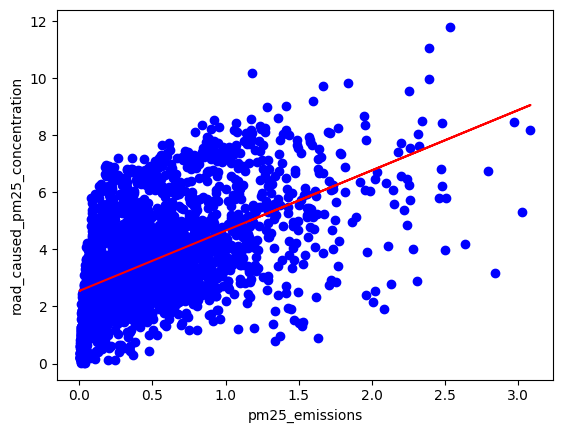

In [252]:
%matplotlib inline
plt.xlabel("pm25_emissions")
plt.ylabel("road_caused_pm25_concentration")
plt.scatter(combined_cleaned_df['pm2.5'], combined_cleaned_df["road_emission_caused_concentration_pm25"], color="blue")
plt.plot(combined_cleaned_df['pm2.5'], combined_cleaned_df['Predicted_pm25_Concentration'], color='red', label='Regression line')
plt.show()

In [119]:
PM25_CONC_MAE = mean_absolute_error(PM_CONC_test, PM25_CONC_pred)
PM25_CONC_MSE = mean_squared_error(PM_CONC_test, PM25_CONC_pred)
PM25_CONC_R2 = r2_score(PM_CONC_test, PM25_CONC_pred)
print(f"Linear Regression PM25 Performance:\n MAE: {PM25_CONC_MAE}\n MSE: {PM25_CONC_MSE}\n R²: {PM25_CONC_R2}")

Linear Regression PM25 Performance:
 MAE: 1.2865125715520507
 MSE: 2.6112027727983826
 R²: 0.2875595494059391


---
# Part Three: Combine the parts, Part One resulted in a DataFrame of Source and Emission by TOID. Part Two resulted in models allowing translation of Emission into Pollutant. So here we run Emissions from Part One through the models created in Part Two

Create a new DataFrame which contains pertinents fields from summary_df

In [122]:
total_list = ["NOX_Total","PM25_Total"]
total_list.extend(TOP_IMPORTANCE)
final_df = summary_df[total_list].copy()

Predict the concentration based on emissions by TOID

In [124]:
final_df['Predicted_Nox_Concentration'] = nox_emission_conc_model.predict(final_df[['NOX_Total']])
final_df['Predicted_Pm25_Concentration'] = nox_emission_conc_model.predict(final_df[['PM25_Total']])

/home/pete/anaconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/home/pete/anaconda3/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Clean up

In [126]:
final_df.drop(columns=["NOX_Total","PM25_Total"], axis=1, inplace=True)

Would ideally have correct limits here, but the lowest for both concentrations is 10.58, and if there is only one value in a DataSet LogisticRegression wont work. So raise LIMITS to allow some values to be false.

In [128]:
LIMIT_NOX=10.7 #Should be 10.0
LIMIT_PM25=10.7 # Should be 5.0
final_df['Predicted_Pm25_Conc_Above_Limit'] = final_df['Predicted_Pm25_Concentration'] > LIMIT_PM25
final_df['Predicted_Nox_Conc_Above_Limit'] = final_df['Predicted_Nox_Concentration'] > LIMIT_NOX


In [129]:
final_df.describe()

,VKM_Diesel_LGV,VKM_Diesel_Car,VKM_Petrol_Car,VKM_Electric_Car,Predicted_Nox_Concentration,Predicted_Pm25_Concentration
count,4.502700e+04,4.502700e+04,4.502700e+04,45027.000000,45027.000000,45027.000000
mean,5.357480e+04,1.115234e+05,1.591121e+05,1129.884314,11.060644,10.618359
std,1.331754e+05,2.426383e+05,3.479764e+05,2405.209402,0.815399,0.018809
min,1.700000e+01,1.400000e+02,1.930000e+02,2.000000,10.609625,10.608189
25%,9.605000e+03,2.071800e+04,2.918450e+04,221.000000,10.710710,10.610374
50%,2.339100e+04,5.075900e+04,7.182400e+04,534.000000,10.844523,10.613310
75%,5.418500e+04,1.178220e+05,1.671525e+05,1220.000000,11.120137,10.619684
max,5.448759e+06,8.911726e+06,1.289498e+07,76361.000000,37.650544,11.304653


In [130]:
final_df["Predicted_Nox_Concentration"].min()

10.609625114240831

# Create Logistic Regression models to predict, based on the VKM of four key classes of vehicle, whether the TOID will be below or above the threshold set here. Which is higher than that set in WHO Air Quality Guideline

In [132]:
vkm_data = final_df[["VKM_Diesel_LGV","VKM_Diesel_Car","VKM_Petrol_Car","VKM_Electric_Car"]]
nox_data = final_df["Predicted_Nox_Conc_Above_Limit"]
pm25_data = final_df["Predicted_Pm25_Conc_Above_Limit"]

## Create model for NOX

In [260]:
VKM_train, VKM_test, Nox_train, Nox_test = train_test_split(vkm_data,nox_data,test_size=0.2)
nox_logistic_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

nox_logistic_reg.fit(VKM_train, Nox_train)
NOX_Predict = nox_logistic_reg.predict(VKM_test)
nox_logistic_reg.score(VKM_test,Nox_test)

0.9339329335998223

In [262]:
accuracy = accuracy_score(Nox_test, NOX_Predict)
precision = precision_score(Nox_test, NOX_Predict)
recall = recall_score(Nox_test, NOX_Predict)
f1 = f1_score(Nox_test, NOX_Predict)
roc_auc = roc_auc_score(Nox_test, nox_logistic_reg.predict_proba(VKM_test)[:, 1])
print(f"LogisticRegression NOX Performance:\n Accuracy: {accuracy}\n Precision: {precision}\n Recall: {recall}\n F1 Score: {f1}\n ROC-AUC: {roc_auc}")

LogisticRegression NOX Performance:
 Accuracy: 0.9339329335998223
 Precision: 0.9609487995371709
 Recall: 0.953364901707562
 F1 Score: 0.9571418281351293
 ROC-AUC: 0.9799909875088169


## Create model for PM25

In [254]:
VKM_train, VKM_test, Pm25_train, Pm25_test = train_test_split(vkm_data,pm25_data,test_size=0.2)
pm25_logistic_reg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
pm25_logistic_reg.fit(VKM_train, Pm25_train)
PM25_Predict = pm25_logistic_reg.predict(VKM_test)
pm25_logistic_reg.score(VKM_test,Pm25_test)

0.9976682211858761

In [256]:
accuracy = accuracy_score(Pm25_test, PM25_Predict)
precision = precision_score(Pm25_test, PM25_Predict)
recall = recall_score(Pm25_test, PM25_Predict)
f1 = f1_score(Pm25_test, PM25_Predict)
roc_auc = roc_auc_score(Pm25_test, pm25_logistic_reg.predict_proba(VKM_test)[:, 1])
print(f"LogisticRegression PM25 Performance:\n Accuracy: {accuracy}\n Precision: {precision}\n Recall: {recall}\n F1 Score: {f1}\n ROC-AUC: {roc_auc}")


LogisticRegression PM25 Performance:
 Accuracy: 0.9976682211858761
 Precision: 0.8382352941176471
 Recall: 0.8507462686567164
 F1 Score: 0.8444444444444444
 ROC-AUC: 0.9995625408030883


## Make predictions about whether given VKM results in being above or below the threshold concentration 

NOx

In [142]:
get_prediction_df = pd.DataFrame({'VKM_Diesel_LGV':[1000000000], 'VKM_Diesel_Car':[100000000], 'VKM_Petrol_Car':[10000000], 'VKM_Electric_Car':[10000000]})
nox_logistic_reg.predict(get_prediction_df)

array([ True])

In [143]:
get_prediction_df = pd.DataFrame({'VKM_Diesel_LGV':[100], 'VKM_Diesel_Car':[100], 'VKM_Petrol_Car':[100], 'VKM_Electric_Car':[100]})
nox_logistic_reg.predict(get_prediction_df)

array([False])

Pm25

In [145]:
get_prediction_df = pd.DataFrame({'VKM_Diesel_LGV':[1000000000], 'VKM_Diesel_Car':[100000000], 'VKM_Petrol_Car':[10000000], 'VKM_Electric_Car':[10000000]})
pm25_logistic_reg.predict(get_prediction_df)

array([ True])

In [146]:
get_prediction_df = pd.DataFrame({'VKM_Diesel_LGV':[100], 'VKM_Diesel_Car':[100], 'VKM_Petrol_Car':[100], 'VKM_Electric_Car':[100]})
pm25_logistic_reg.predict(get_prediction_df)

array([False])